In [1]:
"""
Created By Kevin Du for OSGC Scholarship Program. Credits to "Neural network powered COVID-19 spread forecasting model"\
by Michał Wieczorek, Jakub Siłka, Marcin Woźniak for architecture and data processing.

https://doi.org/10.1016/j.chaos.2020.110203

~~notes notes notes
Purpose:
Intended result:
Notes: 
    Normalizing by the maximum infection rate hides a lot of the explainability of the model. The maximum infection rate
    of a state heavily depends on the population density, conformity to mask mandates, infection policies, etc. which are now
    potentially hidden due to the normalization
    
    Accuracy is heavily dependent on how many total points taken - having data from different strains to predict the next
    infection rate increases the loss dramatically
"""

'\nCreated By Kevin Du for OSGC Scholarship Program. Credits to "Neural network powered COVID-19 spread forecasting model"by Michał Wieczorek, Jakub Siłka, Marcin Woźniak for architecture and data processing.\n\nhttps://doi.org/10.1016/j.chaos.2020.110203\n\n~~notes notes notes\nPurpose:\nIntended result:\nNotes: \n    Normalizing by the maximum infection rate hides a lot of the explainability of the model. The maximum infection rate\n    of a state heavily depends on the population density, conformity to mask mandates, infection policies, etc. which are now\n    potentially hidden due to the normalization\n    \n    Accuracy is heavily dependent on how many total points taken - having data from different strains to predict the next\n    infection rate increases the loss dramatically\n'

In [2]:
import tensorflow as tf
from keras import layers
import math
import numpy as np
import pandas as pd
import csv
import pprint
import matplotlib.pyplot as plt
from functools import partial

In [3]:
##---------Data Hyperparameters-------------
#number of days in a grouping
time_step = 14

##---------Import of data----------------

#State/territory list (sorted alphabetically)
statelist= [[] for _ in range(58)]

#Total number of regions we are tracking
state_list_size = len(statelist)

#List of non-State and non-DC rows (start counting at 1)
staterowlist=[4,11,15,16,41,46,54]

#folderpath to 
folderpath = r"C:\Kevin\Applications\OSGC Undergraduate scholarship\COVID-19\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports_us" + "\\"

with open(r"C:\Kevin\Applications\OSGC Undergraduate scholarship\Date List.csv") as file:
    reader = csv.reader(file)
    datelist = list(reader)
datelist=datelist[0]

#total count of days of data
count=len(datelist)

for i in range(0, count):
    splitdate = datelist[i].split("/")
    datelist[i] = splitdate[0] + "-" + splitdate[1] + "-20" + splitdate[2]
#print(datelist)

#could optimize by adding the 'columns' as a row, then flipping everything with numpy

#extract all the confirmed cases by date from all the data
for date in datelist:
    filepath = folderpath + date + ".csv"
    with open(filepath) as file:
        reader = csv.reader(file)
        data = list(reader)
    for i in range(58):
        statelist[i].append(data[i+1][5])
    
#Infection rates (Total cases) now stored in an array, with each row [first index] representing a state or region,
#and each column [second index] representing a date for the infection
    
    
#--------------Normalization of data------------   

#Make numpy recognize that data is numerical
statelist = np.array(statelist).astype(float)

#Normalize by the highest infection rate
#should maybe normalize by total population
maxstatelist = np.amax(statelist, axis=1)
statelist = statelist / maxstatelist[:,None]

#Infection rates now in terms of (cases/max) with max as the highest one day infection cases

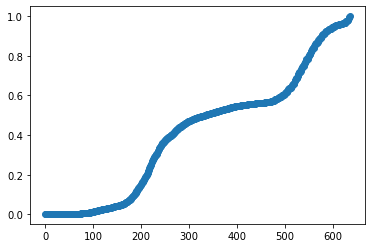

In [4]:
y=statelist[30].tolist()
plt.scatter(range(len(y)),y)

In [9]:
#---------------Imposed Parameters to Match with Policy ANN
#last number of days to use as test data
test_size = 39
#start index of training data [first number of days have incomplete data/are inaccurate]
start_date=0
#end index of the test set, -14 for queue of days required to have 14 days of infection rates for the ANN
end_date=383-14

#---------------Formatting of data---------------
#grouping of data
gstatelist=[]

# group data into a list of first by start date, then by state. 
# Ex. The first 58 column arrays are the infection data for the first day of the 58 regions, in order
for i in range(time_step, count-1):
    for j in range(state_list_size):
        gstatelist.append(statelist[j,(i-time_step):i].tolist())

xtrain_set=gstatelist[start_date*state_list_size:(end_date-test_size)*state_list_size] 
xvalidation_set=gstatelist[(end_date-test_size)*state_list_size:end_date*state_list_size]

ytrain_set=statelist[:,start_date+time_step:end_date+14-test_size].flatten('F').tolist()
yvalidation_set=statelist[:,end_date+14-test_size:end_date+14].flatten('F').tolist()

print(len(gstatelist)/58)
print(len(gstatelist)-start_date*58-90*58)
print()
print(start_date*state_list_size)
print((end_date-test_size)*state_list_size)

#Test print lines to be removed when finished with first draft
print('shape of gstatelist is '+ str(len(gstatelist)) +', '+str(len(gstatelist[0])))
print('length of xtrain is '+ str(len(xtrain_set)))
print('length of ytrain is '+str(len(ytrain_set)))
print('length of xval is '+ str(len(xvalidation_set)))
print('length of yval is '+ str(len(yvalidation_set)))

print('first xtrain looks like: ' + str(xtrain_set[0]))
print('59th xtrain looks like: ' + str(xtrain_set[58]))
print('first ytrain looks like: ' + str(ytrain_set[0]))

print()


621.0
30798

0
19140
shape of gstatelist is 36018, 14
length of xtrain is 19140
length of ytrain is 19140
length of xval is 2262
length of yval is 2262
first xtrain looks like: [0.0038283736041626647, 0.00404030702157336, 0.004218832215549858, 0.004496538072846631, 0.004661491176052986, 0.004757539818426306, 0.004998705431341925, 0.005197066757982477, 0.005390208049711437, 0.005641813732450243, 0.005942487743358028, 0.006158597188697998, 0.006360090536285507, 0.006550099807067509]
59th xtrain looks like: [0.00404030702157336, 0.004218832215549858, 0.004496538072846631, 0.004661491176052986, 0.004757539818426306, 0.004998705431341925, 0.005197066757982477, 0.005390208049711437, 0.005641813732450243, 0.005942487743358028, 0.006158597188697998, 0.006360090536285507, 0.006550099807067509, 0.006759945210513568]
first ytrain looks like: 0.006759945210513568



In [6]:
#df = pd.DataFrame(gstatelist)
#print(df.iloc[:116].to_string())

'''df = pd.DataFrame(statelist,index =['Alabama','Alaska','American Samoa','Arizona','Arkansas','California',
                                        'Colorado','Connecticut','Delaware','Diamond Princess','District of Columbia',
                                        'Florida','Georgia','Grand Princess','Guam','Hawaii','Idaho','Illinois',
                                        'Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
                                        'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada',
                                        'New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota',
                                        'Northern Mariana Islands','Ohio','Oklahoma','Oregon','Pennsylvania','Puerto Rico',
                                        'Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont',
                                        'Virgin Islands','Virginia','Washington','West Virginia','Wisconsin','Wyoming'])'''
#print(df.iloc[:,:15].to_string())

#Infection rates (input set) are now in sets of 14 days, with the last three months of data reserved for validation 
#(testing set will come from most recent data not included)
#

"df = pd.DataFrame(statelist,index =['Alabama','Alaska','American Samoa','Arizona','Arkansas','California',\n                                        'Colorado','Connecticut','Delaware','Diamond Princess','District of Columbia',\n                                        'Florida','Georgia','Grand Princess','Guam','Hawaii','Idaho','Illinois',\n                                        'Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',\n                                        'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada',\n                                        'New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota',\n                                        'Northern Mariana Islands','Ohio','Oklahoma','Oregon','Pennsylvania','Puerto Rico',\n                                        'Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont',\n                                 

In [14]:
#hyperparameters
#input_shape=(14,)
#neuron



model = tf.keras.models.Sequential()
model.add(layers.Dense(units = 256, activation = 'tanh', input_shape = (14,)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(units = 96, activation = 'tanh'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(units = 48, activation = 'tanh'))
model.add(layers.Dense(units = 28, activation = 'tanh'))
model.add(layers.Dense(units = 48, activation = 'tanh'))
model.add(layers.Dense(units = 12, activation = 'tanh'))
model.add(layers.Dense(units = 6, activation = 'tanh'))
model.add(layers.Dense(units = 1, activation = 'relu'))
#need to find a better loss and metric for compiler for covid data- paper doesn't specify much past what is here
model.compile(optimizer = 'Nadam', loss = 'mean_squared_error')




In [15]:
# ANN without policy data fit
model.fit(xtrain_set, ytrain_set, epochs =10)
test_loss = model.evaluate(xvalidation_set, yvalidation_set)
print(test_loss)

Epoch 1/10
599/599 [==============================] - 1s 943us/step - loss: 0.0020
Epoch 2/10
599/599 [==============================] - 1s 950us/step - loss: 4.3952e-04
Epoch 3/10
599/599 [==============================] - 1s 950us/step - loss: 3.9807e-04
Epoch 4/10
599/599 [==============================] - 1s 1ms/step - loss: 3.1596e-04
Epoch 5/10
599/599 [==============================] - 1s 957us/step - loss: 3.3197e-04
Epoch 6/10
599/599 [==============================] - 1s 967us/step - loss: 3.2743e-04
Epoch 7/10
599/599 [==============================] - 1s 948us/step - loss: 3.2348e-04
Epoch 8/10
599/599 [==============================] - 1s 948us/step - loss: 3.2109e-04
Epoch 9/10
599/599 [==============================] - 1s 945us/step - loss: 2.9116e-04
Epoch 10/10
71/71 [==============================] - 0s 486us/step - loss: 1.1950e-04
0.00011950234329560772


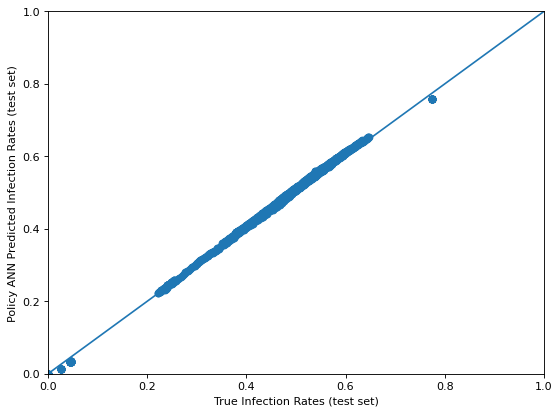

In [16]:
plt.figure(figsize=(8, 6), dpi=80)
predictions = model.predict(xvalidation_set)
plt.scatter(yvalidation_set,predictions)
plt.xlabel('True Infection Rates (test set)')
plt.ylabel('Policy ANN Predicted Infection Rates (test set)')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

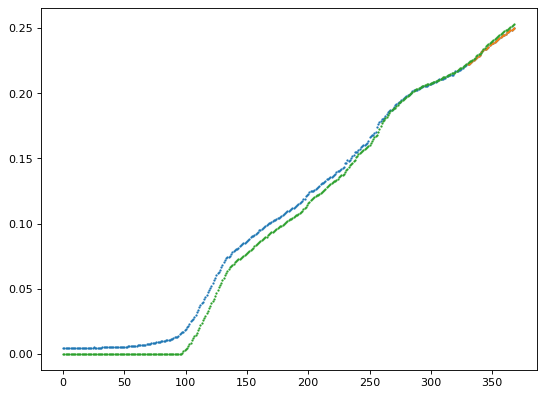

In [22]:
plt.figure(figsize=(8, 6), dpi=80)
xvalues = xtrain_set+xvalidation_set
yvalues = ytrain_set+yvalidation_set
index =list(range(int(len(xvalues)/state_list_size)))

territory =15
xstate=[]
ystate=[]
for i in range(int(len(xvalues)/state_list_size)):
    xstate.append(xvalues[territory+i*state_list_size])
    ystate.append(yvalues[territory+i*state_list_size])

plt.scatter(index, ystate, s=1)
plt.scatter(index[-test_size:], ystate[-test_size:], s=1)

predictions = model.predict(xstate)
plt.scatter(index, predictions, s=1)